In [118]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import nltk.stem as stem
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
import gensim
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
# import category_encoders as ce
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPRegressor
import random
import pandas as pd

In [119]:
data_dir = '/content/drive/My Drive/data/predictBookprices'

In [120]:
df = pd.read_csv(data_dir + '/Data_Train.csv', encoding='cp1252')

In [121]:
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [122]:
df.shape

(6237, 9)

In [123]:
df.isna().sum()

Title           0
Author          0
Edition         0
Reviews         0
Ratings         0
Synopsis        0
Genre           0
BookCategory    0
Price           0
dtype: int64

In [124]:
def prepare_data(df):
    ''' cleaning data - fields Reviews, Ratings and Edtition'''
    
    df['Ratings'] = df.Ratings.str.split().str.get(0).str.replace(',', '').astype('int32')
    df['Reviews'] = df.Reviews.str.split().str.get(0).astype('float')
    df['Edition_type'] = df.Edition.str.split(',').str.get(0)
    df['Edition_year'] = df.Edition.str.split().str.get(-1)
    df = df.drop(columns=['Edition'])
    return df

In [125]:
df = prepare_data(df)
# df.to_csv("Data/new_data.csv", index=None)
# data = pd.read_csv("Data/new_data.csv")
df.head()


,Title,Author,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Edition_type,Edition_year
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,2016
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,2012
2,Leviathan (Penguin Classics),Thomas Hobbes,4.8,6,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,1982
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,4.1,13,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,2017
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,5.0,1,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,2006


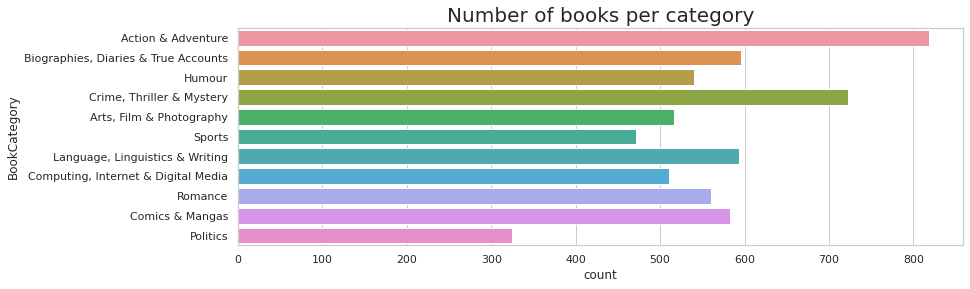

In [126]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="BookCategory", data=df).set_title("Number of books per category",fontsize=20)
plt.show()

In [127]:
data = df

Text(0.5, 1.0, 'Price of Books vs reviews')

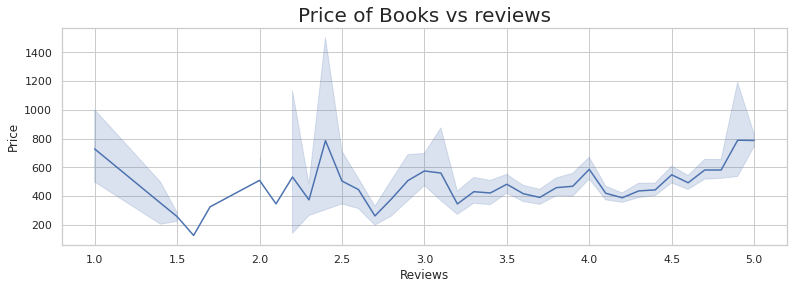

In [128]:
plt.figure(figsize=(13, 4))
sns.lineplot(x="Reviews", y="Price", data=data).set_title("Price of Books vs reviews",fontsize=20)

Text(0.5, 1.0, 'Price of Books vs No. of Ratings')

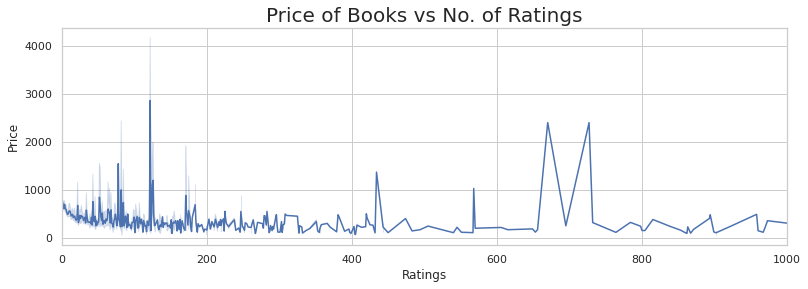

In [129]:
plt.figure(figsize=(13, 4))
ax = sns.lineplot(x="Ratings", y="Price", data=data)
ax.set_xlim([0,1000])
ax.set_title("Price of Books vs No. of Ratings",fontsize=20)

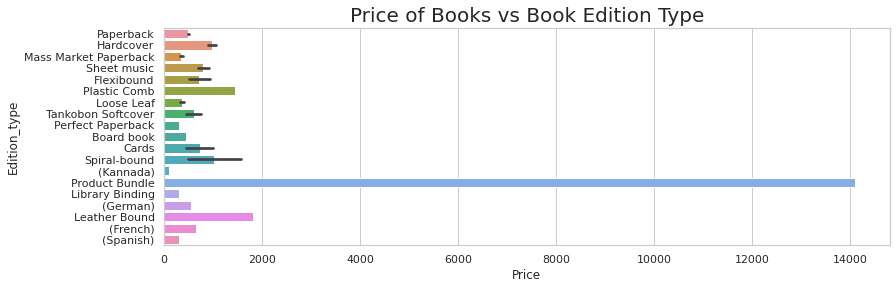

In [130]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.barplot(x="Price", y="Edition_type", data=data).set_title("Price of Books vs Book Edition Type",fontsize=20)
plt.show()

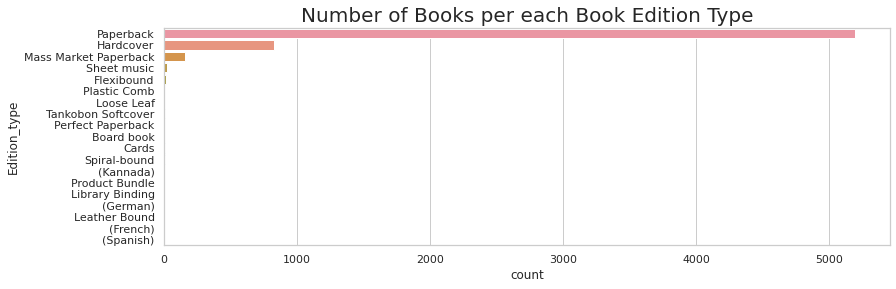

In [131]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="Edition_type", data=data).set_title("Number of Books per each Book Edition Type",fontsize=20)
plt.show()

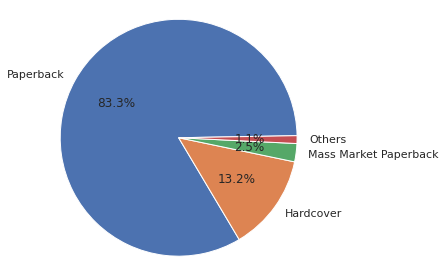

In [132]:
x = dict(data['Edition_type'].value_counts())
total = 0
for i, j in x.items():
    if j <= 24:
        total+=j
keys = [i for i, j in x.items() if j > 24]
keys.append("Others")
values = [j for i, j in x.items() if j > 24]
values.append(total)
labels = keys
sizes = values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=1)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [133]:
counts = pd.value_counts(data['Edition_type'])
mask = data['Edition_type'].isin(counts[counts > 24].index)
data['Edition_type'][~mask] = "Other_editions"

In [134]:
data['Edition_type'].value_counts()

Paperback                5193
Hardcover                 823
Mass Market Paperback     155
Other_editions             66
Name: Edition_type, dtype: int64

In [135]:
counts = pd.value_counts(data['Genre'])
mask = data['Genre'].isin(counts[counts > 7].index)
data['Genre'][~mask] = "Other_genres"

In [136]:
counts = pd.value_counts(data['Author'])
mask = data['Author'].isin(counts[counts > 2].index)
data['Author'][~mask] = "Other_authors"

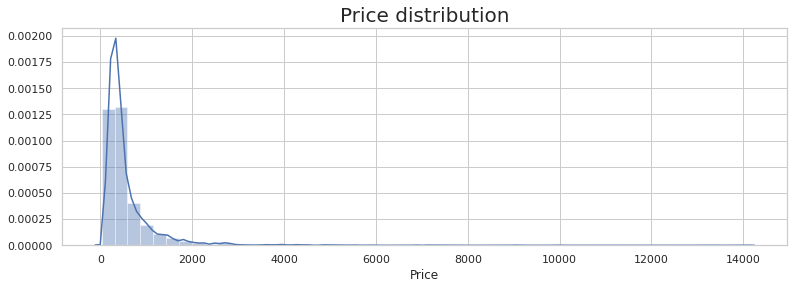

In [137]:
plt.figure(figsize=(13, 4))
sns.distplot(data['Price']).set_title("Price distribution", fontsize=20)
plt.show()

In [138]:
import re
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    # text = text.split()

    return text

In [139]:
import string
data['Synopsis'] = data['Synopsis'].apply(text_to_word_list)
data["num_words_synops"] = data["Synopsis"].apply(lambda x: len(str(x).split()))
## Number of characters in the Synopsis ##
data["num_chars_synops"] = data["Synopsis"].apply(lambda x: len(str(x)))

## Number of punctuations in the Synopsis ##
data["num_punct_synops"] = data['Synopsis'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
data["num_words_title"] = data["Title"].apply(lambda x: len(str(x).split()))
data["mean_word_len"] = data["Synopsis"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

Text(0.5, 1.0, 'Cheaper Books : Top words in titles')

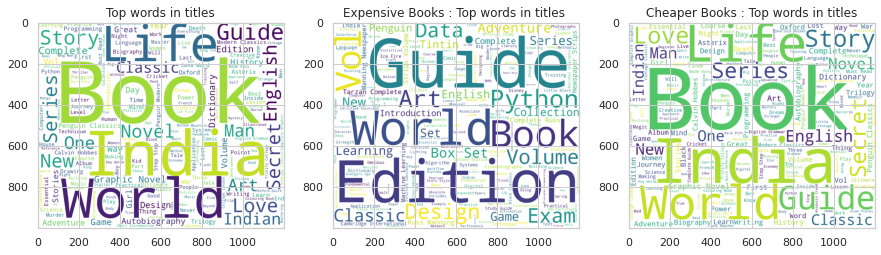

In [140]:
from wordcloud import WordCloud, STOPWORDS
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 15)
text = ' '.join(data['Title'].values)
wordcloud1 = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
data2 = data[data['Price'] >= 1500]
text = ' '.join(data2['Title'].values)
wordcloud2 = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
# plt.imshow(wordcloud)
data2 = data[data['Price'] < 1500]
text = ' '.join(data2['Title'].values)
wordcloud3 = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
ax[0].imshow(wordcloud1)
ax[1].imshow(wordcloud2)
ax[2].imshow(wordcloud3)
ax[0].set_title("Top words in titles")
ax[1].set_title("Expensive Books : Top words in titles ")
ax[2].set_title("Cheaper Books : Top words in titles")


In [141]:
le = LabelEncoder()
le.fit(data['BookCategory'])
data['BookCategory'] = le.transform(data['BookCategory'])

In [142]:
leET = LabelEncoder()
leET.fit(data['Edition_type'])
data['Edition_type'] = leET.transform(data['Edition_type'])

In [143]:
leET = LabelEncoder()
leET.fit(data['Author'])
data['Author'] = leET.transform(data['Author'])

In [144]:
leET = LabelEncoder()
leET.fit(data['Genre'])
data['Genre'] = leET.transform(data['Genre'])

In [145]:
data.head()

,Title,Author,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Edition_type,Edition_year,num_words_synops,num_chars_synops,num_punct_synops,num_words_title,mean_word_len
0,The Prisoner's Gold (The Hunters 3),52,4.0,8,the hunters return in their third brilliant no...,0,0,220.00,3,2016,133,767,1,6,4.766917
1,Guru Dutt: A Tragedy in Three Acts,248,3.9,14,a layered portrait of a troubled genius for wh...,21,2,202.93,3,2012,198,1133,5,7,4.722222
2,Leviathan (Penguin Classics),339,4.8,6,during the time men live without a common pow...,65,6,299.00,3,1982,263,1631,4,3,5.197719
3,A Pocket Full of Rye (Miss Marple),6,4.1,13,a handful of grain is found in the pocket of a...,32,5,180.00,3,2017,76,415,0,7,4.460526
4,LIFE 70 Years of Extraordinary Photography,248,5.0,1,for seven decades life has been thrilling the ...,83,1,965.62,0,2006,106,640,1,6,5.037736


In [146]:
data_ = data.drop(columns=['Title', 'Synopsis'])
data.shape, data.columns

((6237, 15),
 Index(['Title', 'Author', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
        'BookCategory', 'Price', 'Edition_type', 'Edition_year',
        'num_words_synops', 'num_chars_synops', 'num_punct_synops',
        'num_words_title', 'mean_word_len'],
       dtype='object'))

Text(0.5, 1.0, 'Log of Price Distribution (gives Normalk Distr.)')

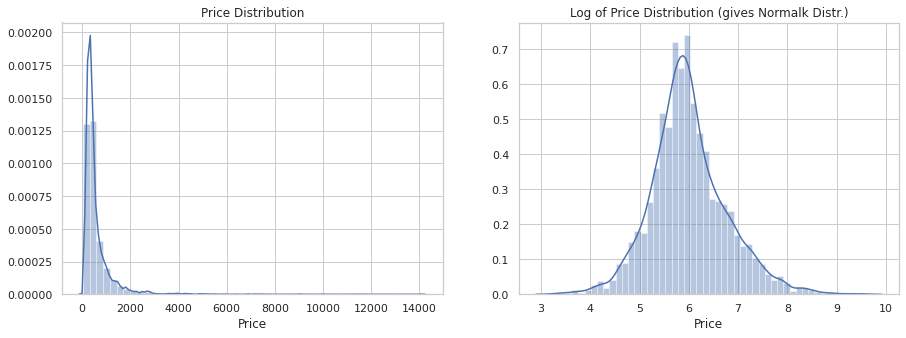

In [155]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 5)
sns.distplot(data['Price'], ax=ax[0])
sns.distplot(np.log1p(data['Price']), ax=ax[1])
ax[0].set_title("Price Distribution")
ax[1].set_title("Log of Price Distribution (gives Normalk Distr.)")
# ax[2].set_title("Cheaper Books : Top words in titles")

In [167]:
label = np.log1p(data['Price'])
final_data = data.drop(columns=['Price', 'Title', 'Synopsis', 'Edition_year'])

In [168]:
final_data.head()

,Author,Reviews,Ratings,Genre,BookCategory,Edition_type,num_words_synops,num_chars_synops,num_punct_synops,num_words_title,mean_word_len
0,52,4.0,8,0,0,3,133,767,1,6,4.766917
1,248,3.9,14,21,2,3,198,1133,5,7,4.722222
2,339,4.8,6,65,6,3,263,1631,4,3,5.197719
3,6,4.1,13,32,5,3,76,415,0,7,4.460526
4,248,5.0,1,83,1,0,106,640,1,6,5.037736


In [169]:
x_train, x_test, y_train, y_test = train_test_split(final_data, label, test_size=0.10, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5613, 11), (624, 11), (5613,), (624,))

In [183]:
reg_model = DecisionTreeRegressor(max_depth=7)

reg_model.fit(x_train, y_train)

y_pred = reg_model.predict(x_train)
print("Train : ", np.sqrt(np.square(y_pred - y_train).mean()))

predictions = list(reg_model.predict(x_test))
print("test : ", np.sqrt(np.square(predictions - y_test).mean()))
# print("Test: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Train :  0.5973413188723423
test :  0.6742011103563845


In [218]:
import xgboost
# best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.7,
#                  gamma=0,                 
#                  learning_rate=0.07,
#                  max_depth=4,
#                  min_child_weight=1.5,
#                  n_estimators=2000,                                                                    
#                  reg_alpha=0.85,
#                  reg_lambda=0.45,
#                  subsample=0.2,
#                  seed=42)
best_xgb_model = xgboost.XGBRegressor(max_depth= 3, learning_rate=0.1,
                                      n_estimators=2000)
best_xgb_model.fit(x_train,y_train)

y_pred = best_xgb_model.predict(x_train)
print("Train : ", np.sqrt(np.square(y_pred - y_train).mean()))

predictions = list(best_xgb_model.predict(x_test))
print("test : ", np.sqrt(np.square(predictions - y_test).mean()))

[20:53:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train :  0.3278602824239841
test :  0.5870978089907207
